# Parameterization

In [1]:
!gcloud config set project  bwh-midrc-rapid-res-1655321320

Updated property [core/project].


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
project_name = "bwh-midrc-rapid-res-1655321320"
# bucket_name = "midrc-analysis-bwh"
bucket_name = "midrc-analysis-bwh-dk"
# bucket_path = "bpr-results"
bucket_path = "bpr-results/"

dataset_table_id = "midrc_dicom_us" # This already exists 
table_view_id_name = "ct_limited_open_a1_r1_dk"
# table_id = "bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk"


# Environment setup

**Install BodyPartRegression package**

In [4]:
#%%capture 
import shutil
import os
if os.path.isdir('/content/BodyPartRegression'):
  shutil.rmtree('/content/BodyPartRegression')
!pip install torch==1.8.1 pytorch-lightning==1.2.10 torchtext==0.9.1 torchvision==0.9.1 torchaudio==0.8.1 dataclasses==0.6
!pip install bpreg
!git clone https://github.com/MIC-DKFZ/BodyPartRegression.git
# !pip install torch==1.8.1 pytorch-lightning==1.2.10 torchtext==0.9.1
!pip install SimpleITK
!pip install pydicom

import bpreg 
import seaborn as sb 
import pandas as pd 
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt 

!pip install opencv-python-headless==4.1.2.30 # https://stackoverflow.com/questions/70537488/cannot-import-name-registermattype-from-cv2-cv2/70547274
from BodyPartRegression.docs.notebooks.utils import * 

print (pd.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.9/841.9 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 KB 18.9 MB/s eta 0:00:00
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492036 sha256=f258814f78165cc44175d776117b69505874d44f08e31fc721eb7fa11824258d
  Stored in directory: /root/.cache/pip/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built future
  Attempting

In [5]:
from google.cloud import bigquery

In [6]:
!pip install https://github.com/GoogleCloudPlatform/healthcare-api-dicomweb-cli/archive/v1.0.2.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 50.4 kB 18.9 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for dcmweb: filename=dcmweb-1.0.2-py3-none-any.whl size=26439 sha256=13d1c39607879071d4dc84b31b37a94011b528f5726fb81334bbda5ce652f268
  Stored in directory: /tmp/pip-ephem-wheel-cache-fnkjzvya/wheels/72/cb/c0/8e1b6fd05e3af6d751c98b4a316bbe3c5658baedd3f5af98ad
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=40cd411fbb65cb0d3cbbf6beb0822766f054ccdc8d60e28ed0a28f8f053e1791
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
  Created wheel for hurry.filesize: filename=hurry.filesize-0.9-py3-none-any.whl size=4134

In [7]:
# install dcm2niix
!sudo apt-get install dcm2niix 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libyaml-cpp0.5v5
Suggested packages:
  pigz
The following NEW packages will be installed:
  dcm2niix libyaml-cpp0.5v5
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 295 kB of archives.
After this operation, 1,105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libyaml-cpp0.5v5 amd64 0.5.2-4ubuntu1 [150 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dcm2niix amd64 1.0.20171215-1 [145 kB]
Fetched 295 kB in 1s (520 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Di

In [8]:
#install nrrd
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#Install Plastimatch

!sudo apt install plastimatch 
!echo $(plastimatch --version)

if os.path.isdir('/content/pyplastimatch'):
  try:
    shutil.rmtree('/content/pyplastimatch')
  except OSError as err:
    print("Error: %s : %s" % ("pyplastimatch", err.strerror)) 
# !git clone https://github.com/denbonte/pyplastimatch/ pyplastimatch
!git clone https://github.com/AIM-Harvard/pyplastimatch.git 

# from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.pyplastimatch import pyplastimatch as pypla

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libdcmtk12 libdlib-data libdlib18 libfftw3-single3 libinsighttoolkit4.12
  libnifti2
Suggested packages:
  libfftw3-bin libfftw3-dev
The following NEW packages will be installed:
  libdcmtk12 libdlib-data libdlib18 libfftw3-single3 libinsighttoolkit4.12
  libnifti2 plastimatch
0 upgraded, 7 newly installed, 0 to remove and 21 not upgraded.
Need to get 76.0 MB of archives.
After this operation, 162 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libdcmtk12 amd64 3.6.2-3build3 [4,499 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libdlib-data all 18.18-2build1 [63.4 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 

In [10]:
import glob
import numpy as np
from bpreg.scripts.bpreg_inference import bpreg_inference
from google.cloud import storage
import nrrd
import json
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap

# Queries

In [11]:
# %%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320 

# WITH
#   nlst_instances_per_series AS (
#     SELECT
#       DISTINCT(StudyInstanceUID),
#       SeriesInstanceUID,
#       COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
#       COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
#       COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
#       MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
#       MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
#       MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
#       MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
#       STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
#     FROM
#       bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
#     WHERE
#       (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
#     GROUP BY
#       StudyInstanceUID,
#       SeriesInstanceUID
#       ), 
#   nlst_values_per_series AS (
#     SELECT 
#     ANY_VALUE(dicom_all.PatientID) AS PatientID,
#     dicom_all.SeriesInstanceUID,
#     ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
#     ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
#     ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned
#   FROM
#     bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
#   JOIN
#     nlst_instances_per_series
#   ON
#     dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
#   WHERE
#     min_SliceThickness >= 1.5 
#     AND max_SliceThickness <= 3.5 
#     AND nlst_instances_per_series.num_instances > 100
#     AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
#     AND nlst_instances_per_series.orientation_count = 1
#     AND has_localizer = "false"
#   GROUP BY
#     SeriesInstanceUID
#   )
#   SELECT 
#     dicom_all.PatientID,
#     dicom_all.StudyInstanceUID,
#     dicom_all.SeriesInstanceUID,
#     dicom_all.SOPInstanceUID,
#     dicom_all.collection_id,
#     dicom_all.PatientAge,
#     dicom_all.PatientWeight,
#     nlst_values_per_series.num_instances,
#     nlst_values_per_series.SliceThickness,
#     nlst_values_per_series.PatientHeightScanned
#   FROM
#     bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
#   JOIN
#     nlst_values_per_series 
#   ON
#     dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID

In [12]:
# print(len(set(ct_limited_open_a1_r1['PatientID'].values)))
# print(len(set(ct_limited_open_a1_r1['StudyInstanceUID'].values)))
# print(len(set(ct_limited_open_a1_r1['SeriesInstanceUID'].values)))

In [13]:
# %%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320 

query = """
WITH
  nlst_instances_per_series AS (
    SELECT
      # DISTINCT(StudyInstanceUID),
      StudyInstanceUID,
      SeriesInstanceUID,
      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(PixelSpacing,"/"))) AS pixel_spacing_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
      MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
      MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
      MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
      MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
      STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer,
      ANY_VALUE(dicom_all.ImageOrientationPatient) AS ImageOrientationPatient
    FROM
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
    WHERE
      (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
    GROUP BY
      StudyInstanceUID,
      SeriesInstanceUID
      ), 

    distinct_slice_location_difference_values AS (
  SELECT 
      # DISTINCT(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC) - LAG(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) OVER(partition by SeriesInstanceUID ORDER BY SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC) DESC)) AS SliceLocation_difference,
      DISTINCT(TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) - LAG(TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1),1) OVER(partition by SeriesInstanceUID ORDER BY TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) DESC)) AS SliceLocation_difference,
      SeriesInstanceUID,
      StudyInstanceUID
  FROM
      # `bigquery-public-data.idc_current.dicom_all`
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all

  ),

  nlst_values_per_series AS (
  SELECT 
    # ANY_VALUE(dicom_all.PatientID) AS PatientID,
    # dicom_all.SeriesInstanceUID,
    distinct_slice_location_difference_values.SeriesInstanceUID AS SeriesInstanceUID, 
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
    ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
    ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned, 
    COUNT(distinct_slice_location_difference_values.SliceLocation_difference) as num_differences,
    MAX(ABS(distinct_slice_location_difference_values.SliceLocation_difference)) as max_difference,
    MIN(ABS(distinct_slice_location_difference_values.SliceLocation_difference)) as min_difference,
    ANY_VALUE(nlst_instances_per_series.ImageOrientationPatient) AS ImageOrientationPatient
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
    nlst_instances_per_series
  JOIN
    # nlst_instances_per_series
    distinct_slice_location_difference_values
  ON
    # dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
    nlst_instances_per_series.SeriesInstanceUID = distinct_slice_location_difference_values.SeriesInstanceUID 
  WHERE
    nlst_instances_per_series.min_SliceThickness >= 1.5
    AND nlst_instances_per_series.max_SliceThickness <= 3.5
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.pixel_spacing_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false" 
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(0)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(1)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(0)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(2)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(4)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(3)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(4)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(5)] AS float64))
  GROUP BY
    distinct_slice_location_difference_values.SeriesInstanceUID

  )

  SELECT 
    dicom_all.PatientID,
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    dicom_all.SOPInstanceUID, 
    dicom_all.collection_id, 
    dicom_all.PatientAge,
    dicom_all.PatientWeight,
    nlst_values_per_series.num_instances,
    nlst_values_per_series.SliceThickness, 
    nlst_values_per_series.PatientHeightScanned,
    nlst_values_per_series.num_differences,
    nlst_values_per_series.max_difference, 
    nlst_values_per_series.min_difference
  FROM 
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
  JOIN 
    nlst_values_per_series
  ON 
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID 
  WHERE
    nlst_values_per_series.num_differences <= 2
    AND nlst_values_per_series.max_difference/nlst_values_per_series.min_difference < 2
"""

client = bigquery.Client(project=project_name)

table_id = '.'.join([project_name, dataset_table_id, table_view_id_name])
job_config = bigquery.QueryJobConfig(destination=table_id)

# Try to create table 
try: 
  print ('trying to create table: ' + str(table_id))
  query_job = client.query(query, job_config=job_config) 
  result = query_job.result()  
  print ('created table: ' + str(table_id))
# If table already exists, don't do anything
except: 
  print('table ' + str(table_id) + ' already exists')
  pass 



trying to create table: bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk
table bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk already exists


In [14]:
# Get the dataframe from the table 

client = bigquery.Client(project=project_name)
table_id = '.'.join([project_name, dataset_table_id, table_view_id_name])

query_view = f"""
  SELECT 
    * 
  FROM 
    {table_id}
  """ 
job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config) 
ct_limited_open_a1_r1 = result.to_dataframe()


In [15]:
ct_limited_open_a1_r1

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,num_instances,SliceThickness,PatientHeightScanned,num_differences,max_difference,min_difference
0,10000364-1310150,2.16.840.1.114274.1818.56277717926260378856921...,2.16.840.1.114274.1818.46652472987550009305366...,2.16.840.1.114274.1818.46611042193109500771675...,Open-A1,062Y,94.348,152,1.5,226.5,1,1.500000000,1.500000000
1,10000364-1310150,2.16.840.1.114274.1818.56277717926260378856921...,2.16.840.1.114274.1818.46652472987550009305366...,2.16.840.1.114274.1818.56958767487481437501222...,Open-A1,062Y,94.348,152,1.5,226.5,1,1.500000000,1.500000000
2,10000364-1310150,2.16.840.1.114274.1818.56277717926260378856921...,2.16.840.1.114274.1818.46652472987550009305366...,2.16.840.1.114274.1818.51535999809052778591562...,Open-A1,062Y,94.348,152,1.5,226.5,1,1.500000000,1.500000000
3,10000364-1310150,2.16.840.1.114274.1818.56277717926260378856921...,2.16.840.1.114274.1818.46652472987550009305366...,2.16.840.1.114274.1818.53325924708374518603071...,Open-A1,062Y,94.348,152,1.5,226.5,1,1.500000000,1.500000000
4,10000364-1310150,2.16.840.1.114274.1818.56277717926260378856921...,2.16.840.1.114274.1818.46652472987550009305366...,2.16.840.1.114274.1818.53878510159989617247990...,Open-A1,062Y,94.348,152,1.5,226.5,1,1.500000000,1.500000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75550,10000364-6509816,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,229,1.5,342.0,1,1.500000000,1.500000000
75551,10000364-6509816,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,229,1.5,342.0,1,1.500000000,1.500000000
75552,10000364-6509816,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,229,1.5,342.0,1,1.500000000,1.500000000
75553,10000364-6509816,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,229,1.5,342.0,1,1.500000000,1.500000000


In [16]:
print(len(set(ct_limited_open_a1_r1['PatientID'].values)))
print(len(set(ct_limited_open_a1_r1['StudyInstanceUID'].values)))
print(len(set(ct_limited_open_a1_r1['SeriesInstanceUID'].values)))


188
199
389


In [17]:
ct_limited_open_a1_r1.columns

Index(['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'collection_id', 'PatientAge', 'PatientWeight', 'num_instances',
       'SliceThickness', 'PatientHeightScanned', 'num_differences',
       'max_difference', 'min_difference'],
      dtype='object')

In [18]:
ct_limited_open_a1_r1.describe()

,num_instances,SliceThickness,PatientHeightScanned,num_differences
count,75555.000000,75555.000000,75555.000000,75555.000000
mean,255.521183,1.829720,359.442232,1.031752
std,191.898246,0.449865,129.337340,0.175339
min,101.000000,1.500000,168.000000,1.000000
25%,152.000000,1.500000,282.000000,1.000000
50%,194.000000,1.500000,310.500000,1.000000
75%,229.000000,2.000000,418.600000,1.000000
max,997.000000,3.000000,821.250000,2.000000


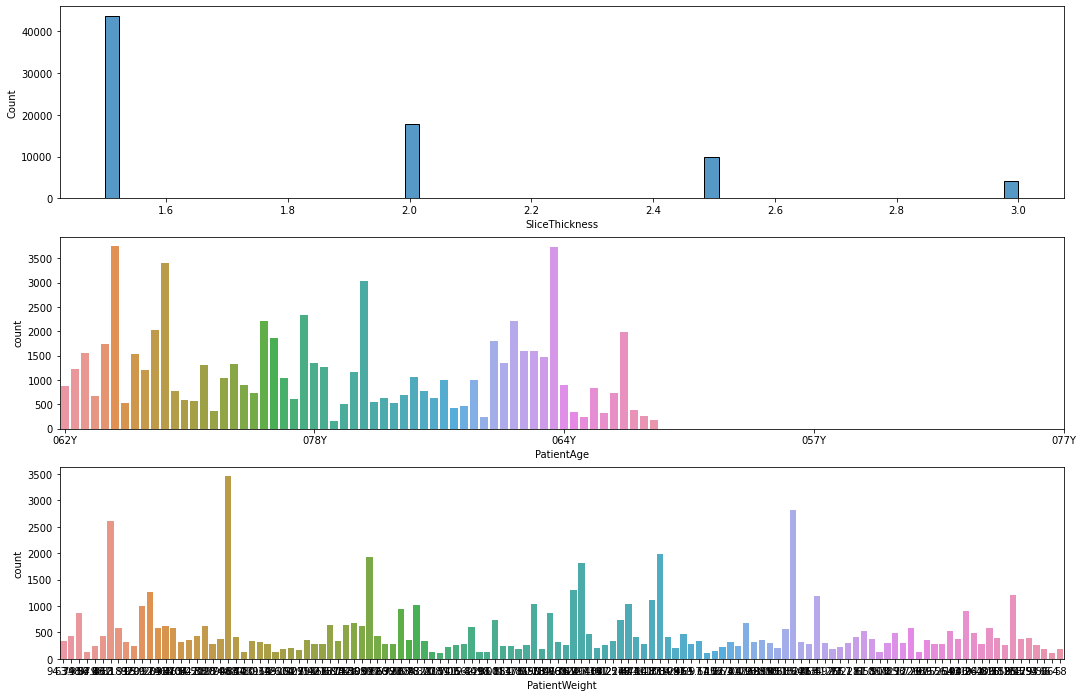

In [19]:
# plot selected

fig, ax = plt.subplots(3, 1, figsize=(18, 12))

x1 = np.random.randint(low=0, high=100, size=100)

# Slice Thickness 
sb.histplot(ax=ax[0], x="SliceThickness", data=ct_limited_open_a1_r1)

# PatientAge
sb.countplot(ax=ax[1], x="PatientAge", data=ct_limited_open_a1_r1)
# ax.set_xticks(np.arange(0, len(x1)+1, 25))
ax[1].set_xticks(np.arange(0, len(x1)+1, 25))

# PatientWeight
sb.countplot(ax=ax[2], x="PatientWeight", data=ct_limited_open_a1_r1)

# BodyPartExamined
#sb.countplot(ax=ax[0], x="BodyPartExamined", data=ct_open_a1_r1)

# PatientSex
#sb.countplot(ax=ax[1], x="PatientSex", data=ct_open_a1_r1)


In [20]:
# series_id_test = "1.3.6.1.4.1.5962.99.1.1247991691.71736179.1616155726490.24430.0"
# df = ct_limited_open_a1_r1[ct_limited_open_a1_r1["SeriesInstanceUID"]==series_id_test]
# df

# Retrieve data using DICOMweb

**Retreive individual instances using DICOMweb protocol**

The code below is adopted from https://cloud.google.com/healthcare-api/docs/samples/healthcare-dicomweb-retrieve-instance#healthcare_dicomweb_retrieve_instance-python

In [21]:
%%capture
!pip install dicomweb-client

**Define the list of SOPInstanceUIDs for the series of interest by getting CT series from the DICOM Store using BigQuery SQL**

In [22]:
def download_series(study_instance_uid, series_instance_uid, sop_instance_uids, dest_dir):
  import pydicom
  token = !gcloud auth print-access-token
  token = token[0]

  PROJECT_ID="bwh-midrc-rapid-res-1655321320"
  REGION="us-central1"

  DATASET_ID="midrc"
  DICOM_STORE_ID="midrc-dicom"
  
  my_project = "bwh-midrc-rapid-res-1655321320"
  location = "us-central1"
  dataset_id = "midrc"
  dicom_store_id = "midrc-dicom"

  # url = f"https://healthcare.googleapis.com/v1/projects/{my_project}/locations/{location}/datasets/{dataset_id}/dicomStores/{dicom_store_id}/dicomWeb"
  # headers = {
  #     "Authorization" : "Bearer %s" % token
  # }

  # import dicomweb_client

  # client = dicomweb_client.api.DICOMwebClient(url, headers=headers)

  # idx=0
  # for sop_instance_uid in sop_instance_uids:
  #   retrievedInstance = client.retrieve_instance(
  #               study_instance_uid=study_instance_uid,
  #               series_instance_uid=series_instance_uid,
  #               sop_instance_uid=sop_instance_uid)
  #   pydicom.filewriter.write_file(f"{dest_dir}/file{idx}.dcm", retrievedInstance)
  #   idx+=1

  # instances = client.retrieve_series(
  #                                     study_instance_uid=study_instance_uid,
  #                                     series_instance_uid=series_instance_uid)
  # idx=0
  # for retrievedInstance in instances: 
  #   pydicom.filewriter.write_file(f"{dest_dir}/file{idx}.dcm", retrievedInstance)
  #   idx+=1

  url = os.path.join('https://healthcare.googleapis.com/v1', 
                     'projects', my_project, 
                     'locations', 'us-central1', 
                     'datasets', dataset_id, 
                     'dicomStores', dicom_store_id, 
                     'dicomWeb/')
  url_study_and_series = os.path.join('studies', 
                                      study_instance_uid,
                                      'series', 
                                      series_instance_uid)
  print (url)
  print(url_study_and_series)

  !dcmweb -m $url retrieve $url_study_and_series $dest_dir
  
  input_dir = os.path.join(dest_dir, study_instance_uid, series_instance_uid)
  !mv $input_dir/* $dest_dir

  # !dcmweb -m \
  # https://healthcare.googleapis.com/v1/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/midrc/dicomStores/midrc-dicom/dicomWeb/ \
  # retrieve studies/2.16.840.1.114274.1818.562777179262603788569215634484746132/series/2.16.840.1.114274.1818.46652472987550009305366336206019799966	\
  # "/content/dcmweb"
  

In [23]:
def file_exists_in_bucket(project_name, bucket_name, file_gs_uri):
  
  """
  Check whether a file exists in the specified Google Cloud Storage Bucket.

  Arguments:
    project_name : required - name of the GCP project.
    bucket_name  : required - name of the bucket (without gs://)
    file_gs_uri  : required - file GS URI
  
  Returns:
    file_exists : boolean variable, True if the file exists in the specified,
                  bucket, at the specified location; False if it doesn't.

  Outputs:
    This function [...]
  """

  storage_client = storage.Client(project = project_name)
  bucket = storage_client.get_bucket(bucket_name)
  
  bucket_gs_url = "gs://%s/"%(bucket_name)
  path_to_file_relative = file_gs_uri.split(bucket_gs_url)[-1]

  print("Searching %s for: \n%s\n"%(bucket_gs_url, path_to_file_relative))

  file_exists = bucket.blob(path_to_file_relative).exists(storage_client)
  
  return file_exists

In [24]:
def visualize_body_parts(fn_png, ct, legs, pelvis, abdomen, chest, shoulderneck, head):
  plt.rcParams['figure.figsize'] = [20, 10]
  fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6)
  xslice = 350
  yslice = int(ct.shape[1]/2.) 
  zslice = 100

  tissuescmap = ListedColormap(['black', # air
  ##organs x 19
  ## https://matplotlib.org/stable/gallery/color/named_colors.html
  'darkred', 'orange', 'yellow',     'green', 'mediumslateblue', 'cyan',
  'purple','coral', 'tan', 'fuchsia',  'chartreuse', 'deepskyblue', 'skyblue', 'indigo', 'lime', 'gold', 'pink',
  'peru', 'olivedrab'])                            

  myslicect = ct[:,yslice,:]
  boxslice1 = legs[:,yslice,:]
  boxslice2 = pelvis[:,yslice,:]
  boxslice3 = abdomen[:,yslice,:]
  boxslice4 = chest[:,yslice,:]
  boxslice5 = shoulderneck[:,yslice,:]
  boxslice6 = head[:,yslice,:]
  a = ct.shape[0]/ct.shape[2]
  o = "lower"

  ax1.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax1.imshow(boxslice1.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax1.set_title('Legs', fontsize=18)

  ax2.imshow(myslicect.T, cmap='gray', aspect = a,origin = o, vmin = -400, vmax = 400)
  ax2.imshow(boxslice2.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax2.set_title('Pelvis',fontsize=18)

  ax3.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax3.imshow(boxslice3.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax3.set_title('Abdomen',fontsize=18)

  ax4.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax4.imshow(boxslice4.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax4.set_title('Chest',fontsize=18)

  ax5.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax5.imshow(boxslice5.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax5.set_title('Shoulder-neck',fontsize=18)

  ax6.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax6.imshow(boxslice6.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax6.set_title('Head',fontsize=18)
  fig.savefig(fn_png,dpi=150)


In [25]:
import logging
urllib3_logger = logging.getLogger('urllib3')
urllib3_logger.setLevel(logging.CRITICAL) # suppress messages upon download

# Process series

In [26]:
def listdir_bucket(project_name, bucket_name, dir_gs_uri):
  
  """
  Export DICOM SEG object from segmentation masks stored in NRRD files.

  Arguments:
    project_name : required - name of the GCP project.
    bucket_name  : required - name of the bucket (without gs://)
    file_gs_uri  : required - directory GS URI
  
  Returns:
    file_list : list of files in the specified GCS bucket.

  Outputs:
    This function [...]
  """

  storage_client = storage.Client(project = project_name)
  bucket = storage_client.get_bucket(bucket_name)
  
  bucket_gs_url = "gs://%s/"%(bucket_name)
  path_to_dir_relative = dir_gs_uri.split(bucket_gs_url)[-1]


  print("Getting the list of files at `%s`..."%(dir_gs_uri))

  file_list = list()

  for blob in storage_client.list_blobs(bucket_name,  prefix = path_to_dir_relative):
    fn = os.path.basename(blob.name)
    file_list.append(fn)

  return file_list

In [27]:
series_id_list = list(set(ct_limited_open_a1_r1["SeriesInstanceUID"].values))
print(len(series_id_list))

389


In [28]:
# exclude from processing all the patients for which a DICOM SEG object was exported already
# (stored in the specified Google Cloud Storage Bucket)
bucket_json_folder_uri_bpr = os.path.join("gs://", bucket_name, bucket_path)
print("bucket_json_folder_uri_bpr: " + str(bucket_json_folder_uri_bpr))

json_bucket_list = listdir_bucket(project_name = project_name, # or gcs.listdir_bucket
                                  bucket_name = bucket_name,
                                  dir_gs_uri = bucket_json_folder_uri_bpr)

# already_processed_id_list = [f.split("_SEG")[0] for f in json_bucket_list if f.endswith(".json")]
already_processed_id_list = [f.split(".json")[0] for f in json_bucket_list if f.endswith(".json")]

print("\nFound %g series already processed."%(len(already_processed_id_list)))

series_to_process_id_list = sorted(list(set(series_id_list) - set(already_processed_id_list)))

print("Moving on with the remaining %g..."%(len(series_to_process_id_list)))

bucket_json_folder_uri_bpr: gs://midrc-analysis-bwh-dk/bpr-results/
Getting the list of files at `gs://midrc-analysis-bwh-dk/bpr-results/`...

Found 379 series already processed.
Moving on with the remaining 10...


In [ ]:
# This one has 735 files! 
# study_id = 1.3.6.1.4.1.5962.99.1.1247991691.71736179.1616155726490.22155.0
# series_id = 1.3.6.1.4.1.5962.99.1.1247991691.71736179.1616155726490.24430.0

In [29]:
# Processing series

path_downloaded = '/content/downloaded_data'
path_nifti = '/content/nifti_data'
path_json =  '/content/json_data'
path_nrrd = '/content/nrrd_data'

df = ct_limited_open_a1_r1

seriesuid_all = list(set(df['SeriesInstanceUID'].tolist()))
print('total series:', len(seriesuid_all))

#seriesuid_all = ['1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334']

#for seriesuid in [seriesuid_all[14]]:

#for seriesuid in seriesuid_all[0:25]:
# for seriesuid in seriesuid_all:
# for seriesuid in seriesuid_all[0:1]:
for seriesuid in series_to_process_id_list: 

  # print('\n\nSeries %d / %d' %( seriesuid_all.index(seriesuid), len(seriesuid_all)) )
  print('\n\nSeries %d / %d' %( series_to_process_id_list.index(seriesuid), len(series_to_process_id_list)) )

  # clean up from previous iterations and recreate temp directories
  if 1:
    for x in [path_downloaded, path_nifti, path_json, path_nrrd]:
      if os.path.isdir(x):
        try:
          shutil.rmtree(x)
        except OSError as err:
          print("Error: %s : %s" % (x, err.strerror))  
      os.mkdir(x)

  studyuids = list(set(df[df['SeriesInstanceUID']==seriesuid]['StudyInstanceUID'].tolist()))
  if len(studyuids)!=1:
    print('error - not one UID for this series', studyuids)
    print(studyuids)
    1/0
  studyuid = studyuids[0]
  sops = df[ (df['StudyInstanceUID']==studyuid) & (df['SeriesInstanceUID']==seriesuid) ]['SOPInstanceUID'].tolist()

  print(len(sops), seriesuid)

  url_ohif = "https://idc-tester-1.web.app/projects/idc-external-019/locations/us-central1/datasets/midrc/dicomStores/midrc-dicom/study/%s?seriesInstanceUID=%s" % (studyuid,seriesuid)
  print(url_ohif)

  # file_gs_uri = "gs://%s/%s/non-axial/%s.json" % (bucket_name, bucket_path, seriesuid)
  # if file_exists_in_bucket(project_name, bucket_name, file_gs_uri):
  #   print("SKIP EXISTING NONAXIAL", seriesuid)
  #   continue

  # file_gs_uri = "gs://%s/%s/%s.json" % (bucket_name, bucket_path, seriesuid)
  # if file_exists_in_bucket(project_name, bucket_name, file_gs_uri):
  #   print("SKIP EXISTING GOOD", seriesuid)
  #   continue

  # download series
  download_series(studyuid, seriesuid, sops, path_downloaded)

  #convert to nifti
  print('converting to NIFTI')
  cmd = 'dcm2niix -z y -m y -o %s  %s ' % (path_nifti, path_downloaded)
  print(cmd)
  os.system(cmd)

  #define nii file to convert to nrrd
  files = glob.glob(os.path.join(path_nifti,"*.nii.gz"))
  x = [len(x) for x in files]
  nii_good = files[np.argmin(x)]
  print(files)
  print('USING ', nii_good)
  for x in files:
    if x!=nii_good:
      print('   Deleted ',x )
      os.remove(x)
  # Include additional check to see if number of slices in nii file is the same as the number of dicom files 
  nii = nib.load(nii_good)
  img = nii.get_fdata()
  dim_z = img.shape[2]
  num_dicom_files = len([f for f in os.listdir(path_downloaded) if f.endswith('.dcm')])
  if (num_dicom_files != dim_z):
    print('Number of DICOM files downloaded: ' + str(num_dicom_files) + ' does not equal z dim of nifti file: ' + str(dim_z) + '. Skipping series.')
    continue 

  # body part regression
  print('running BPREG')
  bpreg_inference(path_nifti, path_json)

  # Convert image to nrrd and read as numpy array
  print('converting NII to NRRD')
  # file_path_nrrd = os.path.join(path_nrrd,  "ct.nrrd")
  file_path_nrrd = os.path.join(path_nrrd,  "ct_%s.nrrd" % seriesuid) # convention from Lung analysis notebook 
  log_file_path_nrrd = os.path.join(path_nrrd, 'pypla.log')
  convert_args_ct = {"input" : nii_good, "output-img" : file_path_nrrd}
  verbose = True
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)
  # read nrrd CT
  ct, ctheader = nrrd.read(file_path_nrrd)
  print(ct.shape)

  # find and rename the json file from BPREG output
  files = glob.glob(os.path.join(path_json,"*.json"))
  if len(files)!=1:
    print('error: not exactly one json file', files)
    1/0
  # rename json file 
  fn = os.path.split(files[0])[-1][:-5]
  print(fn)
  fn_new= seriesuid+'.json'
  # need quotes around filename to escape "bmi>30" etc special characters
  cmd = 'mv "%s" %s' % (files[0], os.path.join(path_json,fn_new))
  print(cmd)
  os.system(cmd)

  # read labels and z-slices for predicted body parts
  fileObject = open(os.path.join(path_json, fn_new), "r")
  jsonContent = fileObject.read()
  aList = json.loads(jsonContent)

  # check for dimension errors in case of Sagittal or Coronal protocol
  image_size_z = ct.shape[2]
  error_z = False
  for (bodypart, zlist) in aList['body part examined'].items():
    print(bodypart, zlist)
    for z in zlist:
      if z >= image_size_z:
        error_z = True
  if error_z:
    print('SKIP Dimension error, Sagittal or Coronal protocol?')

  # DK additional check - make sure valid z-spacing is not equal to 0
  valid_z_spacing = aList["valid z-spacing"]
  if (valid_z_spacing < 1.0):
    print ('SKIP valid z-spacing is less than 1, file could be corrupted')
    continue 

  # if all good, copy BPREG json to the bucket
  if not error_z:
    cmd = "gsutil cp %s/%s gs://%s/%s" % (path_json, fn_new, bucket_name, bucket_path)
    print(cmd)
    os.system(cmd)
  else:
    # copy json to non-axial folders and DO NOT VISUALIZE
    cmd = "gsutil cp %s/%s gs://%s/%s/non-axial" % (path_json, fn_new, bucket_name, bucket_path)
    print(cmd)
    os.system(cmd)
    continue

  # Copy the ct nrrd file to the bucket - do this here instead of in Lung mask notebook 
  cmd2 = "gsutil cp %s gs://%s/%s" % (file_path_nrrd, bucket_name, bucket_path) 
  print(cmd2)
  os.system(cmd2)

  # write out nrrd masks for body parts
  for (bodypart, zlist) in aList['body part examined'].items():
      print(bodypart, zlist)
      lmbox = np.zeros(ct.shape,dtype=np.short)
      for z in zlist:
          #lmbox[:,:,512-1-int(z)]=1
          lmbox[:,:,int(z)]=1
      fn = os.path.join(path_nrrd, 'box-%s.nrrd' % bodypart)
      nrrd.write(fn, lmbox,  header = ctheader)

  fnlegs_in ='/content/nrrd_data/box-legs.nrrd'
  fnpelvis_in ='/content/nrrd_data/box-pelvis.nrrd'
  fnabdomen_in ='/content/nrrd_data/box-abdomen.nrrd'
  fnchest_in ='/content/nrrd_data/box-chest.nrrd'
  fnshoulderneck_in ='/content/nrrd_data/box-shoulder-neck.nrrd'
  fnhead_in ='/content/nrrd_data/box-head.nrrd'

  legs, legsheader = nrrd.read(fnlegs_in)
  pelvis, pelvisheader = nrrd.read(fnpelvis_in)
  abdomen, abdomenheader = nrrd.read(fnabdomen_in)
  chest, chestheader = nrrd.read(fnchest_in)
  shoulderneck, shoulderneckheader = nrrd.read(fnshoulderneck_in)
  head, headheader = nrrd.read(fnhead_in)

  # visualize and save to bucket
  print('visualizing')
  fn_png = os.path.join(path_json, '%s.png' % seriesuid)
  visualize_body_parts(fn_png, ct, legs, pelvis, abdomen, chest, shoulderneck, head)
  # !gsutil cp /content/json_data/file_png gs://{bucket_name}/{bucket_path}/
  cmd = "gsutil cp %s gs://%s/%s" % (fn_png, bucket_name, bucket_path)
  print(cmd)
  os.system(cmd)


total series: 389


Series 0 / 10
107 1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618866294295.42451.0
https://idc-tester-1.web.app/projects/idc-external-019/locations/us-central1/datasets/midrc/dicomStores/midrc-dicom/study/1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618866294295.42450.0?seriesInstanceUID=1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618866294295.42451.0
https://healthcare.googleapis.com/v1/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/midrc/dicomStores/midrc-dicom/dicomWeb/
studies/1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618866294295.42450.0/series/1.3.6.1.4.1.5962.99.1.3492129840.282517718.1618866294295.42451.0
2023-01-19 20:00:11,357 -- No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2023-01-19 20:00:11,914 -- Saving files into /content/downloaded_data
2023-01-19 20:00:13,728 -- Transferred 6M in 8 files     [
2023-01-19 20:00:15,180 -- Transferred 2

# Create csv of the body parts

In [ ]:
# !pip install git+https://github.com/JoHof/lungmask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-boh7ju4s
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-boh7ju4s
     |████████████████████████████████| 1.1 MB 33.0 MB/s 
     |████████████████████████████████| 4.2 MB 35.2 MB/s 
  Created wheel for lungmask: filename=lungmask-0.2.11-py3-none-any.whl size=17456 sha256=d307ef38245e611814a35c2a971dd39d9fee63bb1c4bce1cd6299752d14e13e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-8msgces5/wheels/b7/62/f7/fd172f57224a95cf73efec4a6029c8a78577dab75b949338d1
Successfully built lungmask


Text(0.5, 1.0, 'Head')

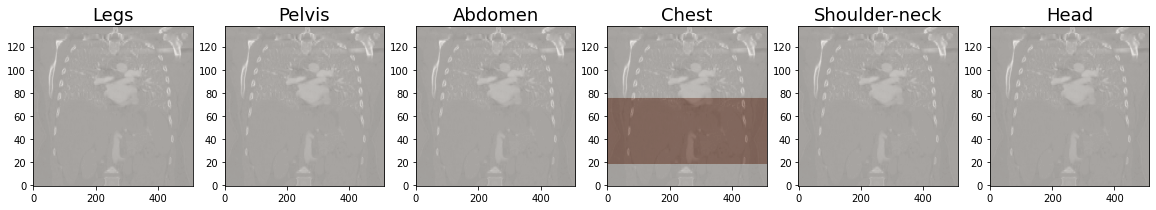

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap

plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6)
xslice = 350
yslice = 250 
zslice = 100

tissuescmap = ListedColormap(['black', # air
##organs x 19
## https://matplotlib.org/stable/gallery/color/named_colors.html
'darkred', 'orange', 'yellow',     'green', 'mediumslateblue', 'cyan',
'purple','coral', 'tan', 'fuchsia',  'chartreuse', 'deepskyblue', 'skyblue', 'indigo', 'lime', 'gold', 'pink',
 'peru', 'olivedrab'])                            

myslicect = ct[:,yslice,:]
boxslice1 = legs[:,yslice,:]
boxslice2 = pelvis[:,yslice,:]
boxslice3 = abdomen[:,yslice,:]
boxslice4 = chest[:,yslice,:]
boxslice5 = shoulderneck[:,yslice,:]
boxslice6 = head[:,yslice,:]
a = ct.shape[0]/ct.shape[2]
o = "lower"

ax1.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax1.imshow(boxslice1.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax1.set_title('Legs', fontsize=18)

ax2.imshow(myslicect.T, cmap='gray', aspect = a,origin = o, vmin = -400, vmax = 400)
ax2.imshow(boxslice2.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax2.set_title('Pelvis',fontsize=18)

ax3.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax3.imshow(boxslice3.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax3.set_title('Abdomen',fontsize=18)

ax4.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax4.imshow(boxslice4.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax4.set_title('Chest',fontsize=18)

ax5.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax5.imshow(boxslice5.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax5.set_title('Shoulder-neck',fontsize=18)

ax6.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax6.imshow(boxslice6.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax6.set_title('Head',fontsize=18)

In [ ]:
# save body part to a single .csv
fn_out = '/content/bpr_by_series.csv'
print(bucket_name, bucket_path)

df = pd.DataFrame(columns = ['SeriesUID','bodypart'])
k=0
storage_client = storage.Client()
blobs = storage_client.list_blobs(bucket_name)
for b in blobs:
  #print(b.name)
  p = os.path.split(b.name)
  # skip non-axial and folders
  if p[0]==bucket_path and p[1].split('.')[-1]=='json':
    k +=1
    seriesuid = '.'.join(p[1].split('.')[:-1])
    #print(b.name)
    contents = storage_client.bucket(bucket_name).blob(b.name).download_as_string()
    jdata = json.loads(contents)
    for (bodypart, zlist) in jdata['body part examined'].items():
      if len(zlist) >0:
        df = df.append( {'SeriesUID': seriesuid, 'bodypart': bodypart }, ignore_index = True)
      if k%10==0:
        print(k,' ', end='')
      if k%120==0:
        print('')
print('\nfiles processed', k)
print(df)
df.to_csv(fn_out, index=False)
cmd = 'gsutil cp %s gs://%s/%s/results-summary/' % (fn_out, bucket_name,bucket_path)
print(cmd)
os.system(cmd)

In [ ]:
file_gs_uri = "gs://%s/%s/%s.json" % (bucket_name, bucket_path, seriesuid)

json_list = glob(os.path.join( pat_dir_path_json,'*.json'))
  print(len(json_list), 'files for this patient')

  for jn in json_list:
    fileObject = open(jn, "r")
    jsonContent = fileObject.read()
    aList = json.loads(jsonContent)

    #print(aList['body part examined'])

    jj = os.path.split(jn)
    jjp = jj[0] # path
    jjn = jj[1] # json file name
    bpfn = os.path.join(jjp, jjn.split('.')[0]+'_bodypart_regr.txt')

    f = open(bpfn,'w')
    for (bodypart, zlist) in aList['body part examined'].items():
      #print(jn)
      print(bodypart, zlist)
      if (len(zlist)>0):
        f.write(bodypart+'\n')
    f.close()
